In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']=150
import seaborn as sns
sns.set()
import meshio
from os.path import join
from glob import glob
import cmocean
from scipy.interpolate import griddata
from tqdm import tqdm
from scipy.io import savemat

In [2]:
def in_circ(x,y):
    '''is the point in the circle?'''
    dist = np.sqrt((x-.2)**2 + (y-.2)**2)
    return dist < .05

def get_data(fp, get_speed=False):
    '''read data in from single file'''
    data    = meshio.read(fp)
    x_and_y = data.points[:,:2]
    v_and_p = np.concatenate([data.point_data['velocity'][:,:2], 
                              data.point_data['pressure']], axis=1)
    if get_speed:
        v_and_p = np.sqrt(v_and_p[:,0]**2 + v_and_p[:,1]**2)[:,None]
    return x_and_y, v_and_p

def regrid(x_and_y, values, x_cutoff=1.65):
    '''Regrid to regular grid, 256 x 64'''
    ### Get subset before interpolation
    idx            = x_and_y[:,0]<x_cutoff
    values_regrid  = griddata(x_and_y[idx], values[idx], (grid_x, grid_y), method='cubic')
    is_in_circ = in_circ(grid_x, grid_y)
    is_in_circ = np.broadcast_to(is_in_circ[...,None], values_regrid.shape)
    values_regrid[is_in_circ]=0.
    return values_regrid.transpose(2,0,1)

def load_sample_interp(fp, get_speed=False):
    '''Load and interpolate single file'''
    x_and_y, v_and_p  = get_data(f, get_speed)
    return regrid(x_and_y, v_and_p)

In [3]:
fp              = '/home/theo/research/elmer2/'

## path when viscosity is fixed
# u_max           = 3.5
# experiment_name = f'nu=1e-3/v={u_max}'

## path when velocity is fixed
u_max           = 1.5
nu              = '5.0e-4'
experiment_name = f'v={u_max:.1f}/nu={nu}'

filenames       = sorted(glob(join(fp,experiment_name, '*.vtu')))
grid_x, grid_y  = np.mgrid[0:1.6:128j, 0:.41:32j] # grid to use

In [4]:
get_speed=False

## Interpolated version
v_and_p_regrid = []
for f in tqdm(filenames):
    v_and_p_regrid.append(load_sample_interp(f,get_speed=get_speed))
v_and_p_regrid = np.stack(v_and_p_regrid,axis=1)    

### raw version
x_and_y_raw, _ = get_data(filenames[0], get_speed=get_speed)
idx            = x_and_y_raw[:,0]<1.65
x_and_y_raw    = x_and_y_raw[idx]
v_and_p_raw    = []
for f in tqdm(filenames):
    _, v_and_p_raw_    = get_data(f, get_speed=get_speed)
    v_and_p_raw.append(v_and_p_raw_)
v_and_p_raw = np.stack(v_and_p_raw,axis=1)[idx]
v_and_p_raw = v_and_p_raw.transpose(2,1,0)

100%|████████████████████████████████████████████████| 2001/2001 [00:04<00:00, 493.58it/s]


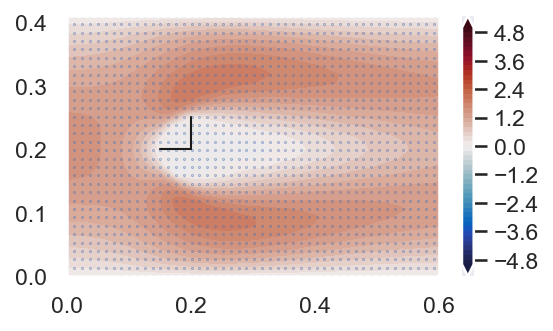

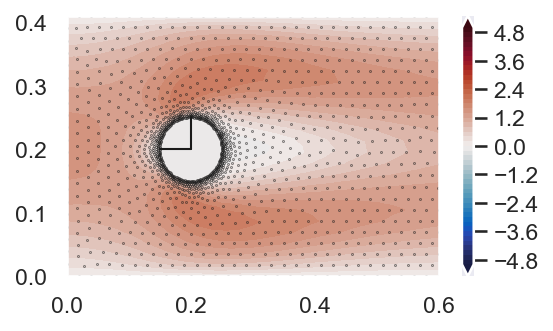

In [5]:
## user input
j           = 0   # variable index
t           = 100 # time index
zoom        = True
show_points = True

## set plot specs
xlim = [0,.6] if zoom else [0,1.6]
figsize=(4,2.3) if zoom else (8,1.65)

## Interpolated
fig,ax=plt.subplots(figsize=figsize)
ax.set_xlim(xlim)

## contourf
p = ax.contourf(grid_x, grid_y , v_and_p_regrid[j,t], levels=np.arange(-5,5.2,.2),
                cmap='cmo.balance', extend='both')
cb = fig.colorbar(p)

## Plot circle radii
ax.plot([.2,.2],[.2,.25],lw=1,c='k')
ax.plot([.15,.2],[.2,.2],lw=1,c='k')

## Plot points
if show_points:
    xy = np.array(list(zip(grid_x.ravel(),grid_y.ravel())))
    ax.scatter(xy[:,0], xy[:,1], s=.05)

plt.show()

## raw
fig,ax=plt.subplots(figsize=figsize)
ax.set_xlim(xlim)

## contourf
p = ax.tricontourf(x_and_y_raw[:,0],x_and_y_raw[:,1],v_and_p_raw[j,t], 
                   levels=np.arange(-5,5.2,.2),cmap='cmo.balance', extend='both')
cb = fig.colorbar(p)

### Plot circle radii
ax.plot([.2,.2],[.2,.25],lw=1,c='k')
ax.plot([.15,.2],[.2,.2],lw=1,c='k')
if show_points:
    ax.scatter(x_and_y_raw[:,0],x_and_y_raw[:,1],s=.05,c='k')

plt.show()

#### Plot input profile

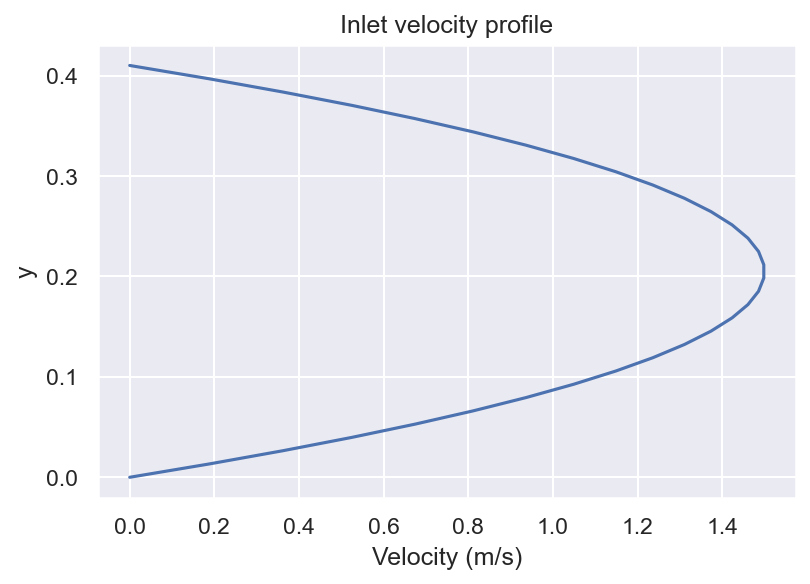

In [6]:
u_in = 4*u_max*grid_y[0,:]*(0.41-grid_y[0,:])/0.41**2
fig,ax=plt.subplots()
ax.plot(u_in, grid_y[0,:])
ax.set_xlabel('Velocity (m/s)')
ax.set_ylabel('y')
ax.set_title('Inlet velocity profile')
plt.show()

## Save to files

In [7]:
## time variable: .0025 step size, but only use every fourth output
time = np.arange(0,.0025*8000+.009,.01)

### Get regridded data
data_interp = { 'uvp'     : v_and_p_regrid,
                't'       : time,
                'x'       : grid_x[:,0],
                'y'       : grid_y[0,:],
                'u_inlet' : u_in}

### Get raw data
# reshape x,y,t data so that dimensions match
x_and_y_raw_reshape = np.repeat(x_and_y_raw.transpose(1,0)[:,None,:], len(time), axis=1)
time_reshape        = np.broadcast_to(time[None,:,None], x_and_y_raw_reshape[:1].shape)
xyt                 = np.concatenate([x_and_y_raw_reshape, time_reshape],axis=0)
data_raw    = { 'uvp'     : v_and_p_raw,
                'xyt'     : xyt}

In [8]:
name = f'nu={nu}_u-in={u_max:.1f}'
savemat(f'data/{name}_interp.mat', data_interp)
savemat(f'data/{name}_raw.mat',    data_raw)